In [1]:
%matplotlib widget
%reload_ext autoreload
%autoreload 2

import typing as t

from matplotlib import pyplot
import matplotlib.patches as patches

import numpy
from numpy.typing import NDArray, ArrayLike

from phaser.utils.num import to_numpy, abs2, fft2, ifft2

import cupy

In [ ]:
from pathlib import Path

from phaser.plan import ReconsPlan

plan = ReconsPlan.from_data({
    'name': 'mos2',
    'backend': 'cupy',

    'raw_data': {
        'type': 'empad',
        'path': "~/Downloads/mos2/1/mos2/mos2_0.00_dstep1.0_x64_y64_4DSTEM.raw",
        'diff_step': 1.0,
        'kv': 120.,
    },

    'init_probe': {
        'type': 'focused',
        'conv_angle': 25.0,
        'defocus': 300.0,
    },

    'init_object': 'random',

    'init_scan': {
        'type': 'raster',
        'shape': [64, 64],
        'step_size': 0.6
    },

    'preprocessing': [{
        'type': 'poisson',
        'scale': 1.0e+6,
    }],

    'engines': [
        {
            'type': 'conventional',
            'probe_modes': 4,
            'niter': 50,
            'grouping': 64,
            'noise_model': {
                'type': 'amplitude',
                'eps': 0.1,
            },
            'solver': {
                'type': 'lsqml',
                'beta_probe': 1.0,
                'beta_object': 1.0,
                'gamma': 1.0e-4,
                'illum_reg_object': 1.0e-2,
                'illum_reg_probe': 1.0e-2,
            },
            'regularizers': [],
            'update_probe': {'after': 1},
            'update_positions': False,
            'save': False,
            'save_images': False,
        },
        {
            'type': 'conventional',
            'probe_modes': 4,
            'niter': 100,
            'grouping': 64,
            'noise_model': {
                'type': 'anscombe',
                'eps': 0.1,
            },
            'solver': {
                'type': 'lsqml',
                'beta_probe': 1.0,
                'beta_object': 1.0,
                'gamma': 1.0e-4,
                'illum_reg_object': 1.0e-2,
                'illum_reg_probe': 1.0e-2,
            },
            'position_solver': {
                'type': 'momentum',
                'momentum': 0.90,
                'step_size': 8e-2,
                'max_step_size': 0.2,
            },
            'regularizers': [],
            'update_probe': True,
            'update_positions': True,
            'save': False,
            'save_images': False,
        },
    ]
})

ConvertError: Expected struct ReconsPlan
While parsing field 'engines':
  Expected sequence of hooks to functions
  While parsing field '0':
    Expected struct ConventionalEnginePlan
      Missing required field 'save_options'
  While parsing field '1':
    Expected struct ConventionalEnginePlan
      Missing required field 'save_options'
  Missing required field 'name'

In [3]:
from phaser.execute import initialize_reconstruction, prepare_for_engine, Observer
from phaser.plan import ConventionalEnginePlan

class MyObserver(Observer):
    def update_group(self, state, force: bool = False):
        super().update_group(state)

    def update_iteration(self, state, i: int, n: int, error: t.Optional[float] = None):
        super().update_iteration(state, i, n, error=error)

xp = cupy
dtype = numpy.float32
observer = MyObserver()
(patterns, state) = initialize_reconstruction(plan, xp, observer)

# run first engine

engine = plan.engines[0]
engine_plan = t.cast(ConventionalEnginePlan, engine.props)
patterns, state = prepare_for_engine(patterns, state, xp, engine_plan)
state = engine({
    'data': patterns,
    'state': state,
    'dtype': dtype,
    'xp': xp,
    'engine_i': 0,
    'observer': observer,
})

INFO:root:Executing plan...
INFO:root:dtype: <class 'numpy.float32'> array backend: cupy
INFO:root:Initializing probe...
INFO:phaser.hooks.probe:Making probe, conv_angle 25.0 mrad, defocus 300.0 A
INFO:root:Initializing scan...
INFO:root:Initializing object...
INFO:phaser.hooks.preprocessing:Adding poisson noise to raw patterns, after scaling by 1.00e+06
INFO:phaser.engines.conventional.run:Starting engine #1...
INFO:phaser.engines.conventional.solvers:Pre-calculated intensities
INFO:phaser.engines.conventional.solvers:Rescaling initial probe intensity by 1.00e+06
INFO:root:Engine initialized
INFO:root:Finished iter  1/50 [00:00.754] Error: 6.699e+03
INFO:root:Finished iter  2/50 [00:00.788] Error: 2.408e+03
INFO:root:Finished iter  3/50 [00:00.782] Error: 1.755e+03
INFO:root:Finished iter  4/50 [00:00.783] Error: 1.703e+03
INFO:root:Finished iter  5/50 [00:00.783] Error: 1.658e+03
INFO:root:Finished iter  6/50 [00:00.781] Error: 1.620e+03
INFO:root:Finished iter  7/50 [00:00.783] Erro

Total time: 00:00:39.322


In [4]:
state.write_hdf5("test.h5")

In [2]:
from phaser.state import ReconsState

ReconsState.read_hdf5("test.h5")

ValueError: While reading 'test.h5':
Path '//wavelength' not found.

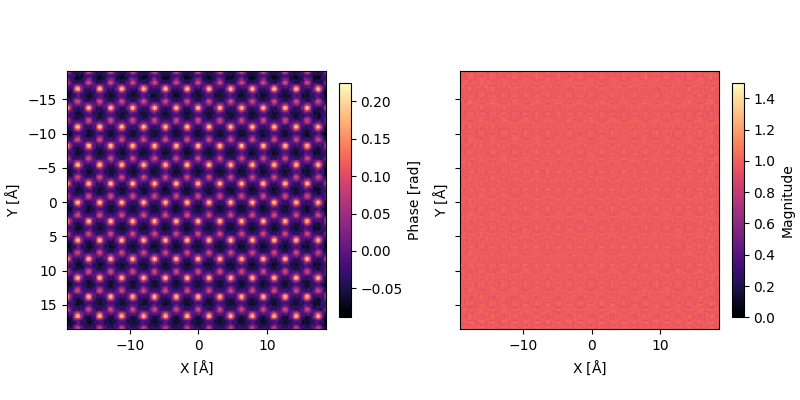

In [40]:
from phaser.utils.plotting import plot_object_phase, plot_object_mag

fig, axs = pyplot.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(8., 4.)

fig.colorbar(plot_object_phase(state.object, ax=axs[0], cmap='magma'), label="Phase [rad]", shrink=0.6)
fig.colorbar(plot_object_mag(state.object, ax=axs[1], cmap='magma', vmin=0., vmax=1.5), label="Magnitude", shrink=0.6)

pyplot.show()

In [11]:
state.probe.sampling.sampling  # A/px

array([0.26165751, 0.26165751])

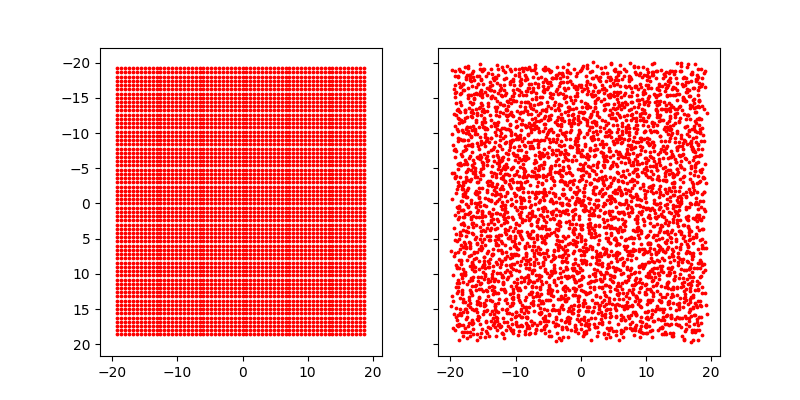

In [49]:
# perturb state with scan noise

mod_state = state.copy()

rng = numpy.random.default_rng(25534)
mod_state.scan += xp.array(rng.normal(scale=0.4, size=mod_state.scan.shape))

fig, axs = pyplot.subplots(ncols=2, sharex=True, sharey=True)
fig.set_size_inches(8., 4.)

axs[0].scatter(to_numpy(state.scan[..., 1]), to_numpy(state.scan[..., 0]), s=3, c='red')
axs[1].scatter(to_numpy(mod_state.scan[..., 1]), to_numpy(mod_state.scan[..., 0]), s=3, c='red')

axs[0].invert_yaxis()

pyplot.show()

In [50]:
from phaser.utils.num import get_array_module
from phaser.state import ReconsState

true_scan = state.scan.copy()
init_scan = mod_state.scan.copy()

class MyObserver(Observer):
    def update_group(self, state, force: bool = False):
        super().update_group(state)

    def update_iteration(self, state: ReconsState, i: int, n: int, error: t.Optional[float] = None):
        super().update_iteration(state, i, n, error=error)
        xp = get_array_module(true_scan, state.scan)

        errors = xp.sqrt((true_scan[..., 1] - state.scan[..., 1])**2 + (true_scan[..., 0] - state.scan[..., 0])**2)
        print(f"Avg position error: {xp.mean(errors)} A")


errors = xp.sqrt((true_scan[..., 1] - mod_state.scan[..., 1])**2 + (true_scan[..., 0] - mod_state.scan[..., 0])**2)
print(f"Initial position error: {xp.mean(errors)} A")

mod_state = plan.engines[1]({
    'data': patterns,
    'state': mod_state,
    'dtype': dtype,
    'xp': xp,
    'engine_i': 1,
    'observer': MyObserver(),
})

INFO:phaser.engines.conventional.run:Starting engine #2...


Initial position error: 0.5004139542579651 A


INFO:phaser.engines.conventional.solvers:Pre-calculated intensities
INFO:phaser.engines.conventional.solvers:Rescaling initial probe intensity by 9.95e-01
INFO:root:Engine initialized
INFO:phaser.engines.conventional.solvers:Position update: mean 0.18740801513195038
INFO:root:Finished iter   1/100 [00:01.092] Error: 1.710e+03


Avg position error: 0.37735283374786377 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.16817905008792877
INFO:root:Finished iter   2/100 [00:01.059] Error: 1.616e+03


Avg position error: 0.26879289746284485 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.16459323465824127
INFO:root:Finished iter   3/100 [00:01.042] Error: 1.444e+03


Avg position error: 0.21835000813007355 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1615300327539444
INFO:root:Finished iter   4/100 [00:01.082] Error: 1.428e+03


Avg position error: 0.20115362107753754 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14785346388816833
INFO:root:Finished iter   5/100 [00:01.086] Error: 1.397e+03


Avg position error: 0.19245855510234833 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1485091596841812
INFO:root:Finished iter   6/100 [00:01.085] Error: 1.372e+03


Avg position error: 0.19061723351478577 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14772148430347443
INFO:root:Finished iter   7/100 [00:01.088] Error: 1.388e+03


Avg position error: 0.18031229078769684 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14293509721755981
INFO:root:Finished iter   8/100 [00:01.085] Error: 1.370e+03


Avg position error: 0.17075851559638977 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14174295961856842
INFO:root:Finished iter   9/100 [00:01.085] Error: 1.350e+03


Avg position error: 0.17141389846801758 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13919886946678162
INFO:root:Finished iter  10/100 [00:01.090] Error: 1.347e+03


Avg position error: 0.16757328808307648 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13618813455104828
INFO:root:Finished iter  11/100 [00:01.088] Error: 1.343e+03


Avg position error: 0.16196860373020172 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13634997606277466
INFO:root:Finished iter  12/100 [00:01.083] Error: 1.330e+03


Avg position error: 0.15943272411823273 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13563448190689087
INFO:root:Finished iter  13/100 [00:01.095] Error: 1.336e+03


Avg position error: 0.1592663824558258 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1332772970199585
INFO:root:Finished iter  14/100 [00:01.097] Error: 1.327e+03


Avg position error: 0.1527199149131775 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13188032805919647
INFO:root:Finished iter  15/100 [00:01.083] Error: 1.334e+03


Avg position error: 0.15153884887695312 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13185231387615204
INFO:root:Finished iter  16/100 [00:01.083] Error: 1.315e+03


Avg position error: 0.15000566840171814 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1310121864080429
INFO:root:Finished iter  17/100 [00:01.087] Error: 1.311e+03


Avg position error: 0.14637456834316254 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13033391535282135
INFO:root:Finished iter  18/100 [00:01.086] Error: 1.310e+03


Avg position error: 0.1463787853717804 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13171876966953278
INFO:root:Finished iter  19/100 [00:01.083] Error: 1.310e+03


Avg position error: 0.14306972920894623 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1323358714580536
INFO:root:Finished iter  20/100 [00:01.087] Error: 1.315e+03


Avg position error: 0.14284460246562958 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13272958993911743
INFO:root:Finished iter  21/100 [00:01.199] Error: 1.321e+03


Avg position error: 0.14292645454406738 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1324736326932907
INFO:root:Finished iter  22/100 [00:01.029] Error: 1.308e+03


Avg position error: 0.14006787538528442 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1323564648628235
INFO:root:Finished iter  23/100 [00:01.078] Error: 1.308e+03


Avg position error: 0.13907131552696228 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13367006182670593
INFO:root:Finished iter  24/100 [00:01.158] Error: 1.321e+03


Avg position error: 0.13812962174415588 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13462169468402863
INFO:root:Finished iter  25/100 [00:01.159] Error: 1.320e+03


Avg position error: 0.1380254328250885 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13528811931610107
INFO:root:Finished iter  26/100 [00:01.160] Error: 1.313e+03


Avg position error: 0.1362508237361908 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1368507742881775
INFO:root:Finished iter  27/100 [00:01.162] Error: 1.323e+03


Avg position error: 0.13663463294506073 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13857543468475342
INFO:root:Finished iter  28/100 [00:01.161] Error: 1.323e+03


Avg position error: 0.1352870911359787 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.13929714262485504
INFO:root:Finished iter  29/100 [00:01.164] Error: 1.326e+03


Avg position error: 0.13631394505500793 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1396072953939438
INFO:root:Finished iter  30/100 [00:01.161] Error: 1.325e+03


Avg position error: 0.13426527380943298 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1406276971101761
INFO:root:Finished iter  31/100 [00:01.165] Error: 1.323e+03


Avg position error: 0.1345180720090866 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14171148836612701
INFO:root:Finished iter  32/100 [00:01.163] Error: 1.327e+03


Avg position error: 0.13279621303081512 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14224842190742493
INFO:root:Finished iter  33/100 [00:01.164] Error: 1.339e+03


Avg position error: 0.13436047732830048 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14298225939273834
INFO:root:Finished iter  34/100 [00:01.162] Error: 1.335e+03


Avg position error: 0.13273295760154724 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14419704675674438
INFO:root:Finished iter  35/100 [00:01.162] Error: 1.340e+03


Avg position error: 0.13372820615768433 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14451417326927185
INFO:root:Finished iter  36/100 [00:01.162] Error: 1.341e+03


Avg position error: 0.13196653127670288 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14450465142726898
INFO:root:Finished iter  37/100 [00:01.163] Error: 1.347e+03


Avg position error: 0.13371822237968445 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1451493203639984
INFO:root:Finished iter  38/100 [00:01.159] Error: 1.346e+03


Avg position error: 0.13220037519931793 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1463385373353958
INFO:root:Finished iter  39/100 [00:01.156] Error: 1.346e+03


Avg position error: 0.1337796300649643 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14763948321342468
INFO:root:Finished iter  40/100 [00:01.160] Error: 1.347e+03


Avg position error: 0.132349893450737 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1484968513250351
INFO:root:Finished iter  41/100 [00:01.161] Error: 1.348e+03


Avg position error: 0.1336514800786972 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14854790270328522
INFO:root:Finished iter  42/100 [00:01.159] Error: 1.347e+03


Avg position error: 0.13264627754688263 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14838659763336182
INFO:root:Finished iter  43/100 [00:01.160] Error: 1.349e+03


Avg position error: 0.13270048797130585 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14846743643283844
INFO:root:Finished iter  44/100 [00:01.161] Error: 1.348e+03


Avg position error: 0.13245147466659546 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14862100780010223
INFO:root:Finished iter  45/100 [00:01.159] Error: 1.351e+03


Avg position error: 0.13250596821308136 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.14924749732017517
INFO:root:Finished iter  46/100 [00:01.160] Error: 1.353e+03


Avg position error: 0.13200126588344574 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1498822271823883
INFO:root:Finished iter  47/100 [00:01.161] Error: 1.350e+03


Avg position error: 0.13372479379177094 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15059198439121246
INFO:root:Finished iter  48/100 [00:01.160] Error: 1.354e+03


Avg position error: 0.13148954510688782 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15118257701396942
INFO:root:Finished iter  49/100 [00:01.160] Error: 1.356e+03


Avg position error: 0.13391707837581635 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15158675611019135
INFO:root:Finished iter  50/100 [00:01.157] Error: 1.356e+03


Avg position error: 0.13120430707931519 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15128347277641296
INFO:root:Finished iter  51/100 [00:01.160] Error: 1.357e+03


Avg position error: 0.13285699486732483 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1506340354681015
INFO:root:Finished iter  52/100 [00:01.164] Error: 1.355e+03


Avg position error: 0.1311037242412567 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15087957680225372
INFO:root:Finished iter  53/100 [00:01.160] Error: 1.355e+03


Avg position error: 0.13239289820194244 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1517789661884308
INFO:root:Finished iter  54/100 [00:01.157] Error: 1.359e+03


Avg position error: 0.13155317306518555 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1524513065814972
INFO:root:Finished iter  55/100 [00:01.154] Error: 1.361e+03


Avg position error: 0.13251827657222748 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15268474817276
INFO:root:Finished iter  56/100 [00:01.154] Error: 1.362e+03


Avg position error: 0.13178707659244537 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15286804735660553
INFO:root:Finished iter  57/100 [00:01.156] Error: 1.358e+03


Avg position error: 0.13247469067573547 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15344952046871185
INFO:root:Finished iter  58/100 [00:01.155] Error: 1.362e+03


Avg position error: 0.13168516755104065 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15380671620368958
INFO:root:Finished iter  59/100 [00:01.153] Error: 1.363e+03


Avg position error: 0.13324126601219177 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15355470776557922
INFO:root:Finished iter  60/100 [00:01.155] Error: 1.362e+03


Avg position error: 0.13118377327919006 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1529521644115448
INFO:root:Finished iter  61/100 [00:01.154] Error: 1.355e+03


Avg position error: 0.1324717253446579 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15301266312599182
INFO:root:Finished iter  62/100 [00:01.152] Error: 1.357e+03


Avg position error: 0.13139565289020538 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15361110866069794
INFO:root:Finished iter  63/100 [00:01.151] Error: 1.356e+03


Avg position error: 0.13266701996326447 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1544368714094162
INFO:root:Finished iter  64/100 [00:01.155] Error: 1.362e+03


Avg position error: 0.1314868927001953 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15459559857845306
INFO:root:Finished iter  65/100 [00:01.151] Error: 1.365e+03


Avg position error: 0.1329858899116516 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15429465472698212
INFO:root:Finished iter  66/100 [00:01.153] Error: 1.366e+03


Avg position error: 0.13088804483413696 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15431047976016998
INFO:root:Finished iter  67/100 [00:01.150] Error: 1.366e+03


Avg position error: 0.13354089856147766 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15489140152931213
INFO:root:Finished iter  68/100 [00:01.152] Error: 1.367e+03


Avg position error: 0.13083814084529877 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15564413368701935
INFO:root:Finished iter  69/100 [00:01.153] Error: 1.365e+03


Avg position error: 0.13394403457641602 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15551984310150146
INFO:root:Finished iter  70/100 [00:01.156] Error: 1.365e+03


Avg position error: 0.1313982754945755 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15528765320777893
INFO:root:Finished iter  71/100 [00:01.156] Error: 1.362e+03


Avg position error: 0.13325008749961853 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15548166632652283
INFO:root:Finished iter  72/100 [00:01.155] Error: 1.362e+03


Avg position error: 0.13152442872524261 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15593425929546356
INFO:root:Finished iter  73/100 [00:01.154] Error: 1.364e+03


Avg position error: 0.1332796961069107 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15619654953479767
INFO:root:Finished iter  74/100 [00:01.155] Error: 1.369e+03


Avg position error: 0.13143067061901093 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15635035932064056
INFO:root:Finished iter  75/100 [00:01.154] Error: 1.367e+03


Avg position error: 0.13328444957733154 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15635602176189423
INFO:root:Finished iter  76/100 [00:01.154] Error: 1.365e+03


Avg position error: 0.13153880834579468 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15624207258224487
INFO:root:Finished iter  77/100 [00:01.153] Error: 1.362e+03


Avg position error: 0.13287897408008575 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1561811864376068
INFO:root:Finished iter  78/100 [00:01.154] Error: 1.366e+03


Avg position error: 0.13156816363334656 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15652361512184143
INFO:root:Finished iter  79/100 [00:01.152] Error: 1.365e+03


Avg position error: 0.13302457332611084 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1567976176738739
INFO:root:Finished iter  80/100 [00:01.150] Error: 1.366e+03


Avg position error: 0.1315024346113205 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15695615112781525
INFO:root:Finished iter  81/100 [00:01.152] Error: 1.367e+03


Avg position error: 0.13318419456481934 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15699224174022675
INFO:root:Finished iter  82/100 [00:01.025] Error: 1.371e+03


Avg position error: 0.13132040202617645 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15700821578502655
INFO:root:Finished iter  83/100 [00:01.009] Error: 1.371e+03


Avg position error: 0.13373415172100067 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15697190165519714
INFO:root:Finished iter  84/100 [00:01.004] Error: 1.371e+03


Avg position error: 0.13080546259880066 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15709364414215088
INFO:root:Finished iter  85/100 [00:01.005] Error: 1.368e+03


Avg position error: 0.13435210287570953 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15747570991516113
INFO:root:Finished iter  86/100 [00:01.005] Error: 1.368e+03


Avg position error: 0.13152939081192017 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15776777267456055
INFO:root:Finished iter  87/100 [00:01.004] Error: 1.369e+03


Avg position error: 0.13394346833229065 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15771640837192535
INFO:root:Finished iter  88/100 [00:01.006] Error: 1.371e+03


Avg position error: 0.13169071078300476 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1576569825410843
INFO:root:Finished iter  89/100 [00:01.004] Error: 1.367e+03


Avg position error: 0.13371442258358002 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15758280456066132
INFO:root:Finished iter  90/100 [00:01.004] Error: 1.367e+03


Avg position error: 0.1314639449119568 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15749120712280273
INFO:root:Finished iter  91/100 [00:01.006] Error: 1.366e+03


Avg position error: 0.1340014934539795 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1576511263847351
INFO:root:Finished iter  92/100 [00:01.009] Error: 1.369e+03


Avg position error: 0.13081030547618866 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1578436940908432
INFO:root:Finished iter  93/100 [00:01.005] Error: 1.369e+03


Avg position error: 0.13457521796226501 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15788736939430237
INFO:root:Finished iter  94/100 [00:01.006] Error: 1.370e+03


Avg position error: 0.13086076080799103 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1580910086631775
INFO:root:Finished iter  95/100 [00:01.008] Error: 1.369e+03


Avg position error: 0.13439401984214783 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1582576483488083
INFO:root:Finished iter  96/100 [00:01.011] Error: 1.370e+03


Avg position error: 0.131116583943367 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15828464925289154
INFO:root:Finished iter  97/100 [00:01.009] Error: 1.370e+03


Avg position error: 0.13425131142139435 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.15801511704921722
INFO:root:Finished iter  98/100 [00:01.005] Error: 1.370e+03


Avg position error: 0.1311008781194687 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1579684466123581
INFO:root:Finished iter  99/100 [00:01.005] Error: 1.368e+03


Avg position error: 0.13403630256652832 A


INFO:phaser.engines.conventional.solvers:Position update: mean 0.1582043319940567
INFO:root:Finished iter 100/100 [00:01.005] Error: 1.370e+03
INFO:root:Solver finished!


Avg position error: 0.13150551915168762 A
Total time: 00:01:51.232


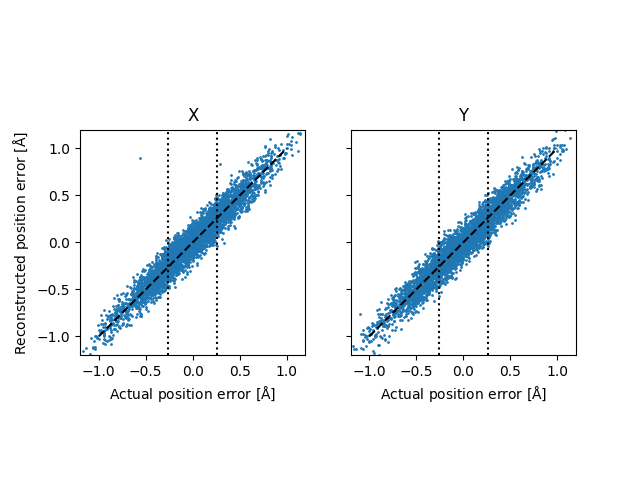

In [51]:
fig, axs = pyplot.subplots(ncols=2, sharex=True, sharey=True)

scan_update_x = to_numpy(mod_state.scan[..., 1] - init_scan[..., 1]).flatten()
scan_error_x = to_numpy(true_scan[..., 1] - init_scan[..., 1]).flatten()
scan_update_y = to_numpy(mod_state.scan[..., 0] - init_scan[..., 0]).flatten()
scan_error_y = to_numpy(true_scan[..., 0] - init_scan[..., 0]).flatten()

axs[0].set_xlim([-1.2, 1.2])
axs[0].set_ylim([-1.2, 1.2])

axs[0].axvline(-state.probe.sampling.sampling[1], linestyle=':', color='black')
axs[0].axvline(state.probe.sampling.sampling[1], linestyle=':', color='black')
axs[1].axvline(-state.probe.sampling.sampling[0], linestyle=':', color='black')
axs[1].axvline(state.probe.sampling.sampling[0], linestyle=':', color='black')

axs[0].plot([-1.0, 1.0], [-1.0, 1.0], '--', color='black')
axs[1].plot([-1.0, 1.0], [-1.0, 1.0], '--', color='black')
axs[0].set_aspect('equal')
axs[1].set_aspect('equal')

axs[0].set_xlabel("Actual position error [$\\mathrm{\\AA}$]")
axs[1].set_xlabel("Actual position error [$\\mathrm{\\AA}$]")
axs[0].set_ylabel("Reconstructed position error [$\\mathrm{\\AA}$]")

axs[0].set_title("X")
axs[0].scatter(scan_error_x, scan_update_x, s=1)
axs[1].set_title("Y")
axs[1].scatter(scan_error_y, scan_update_y, s=1)

pyplot.show()

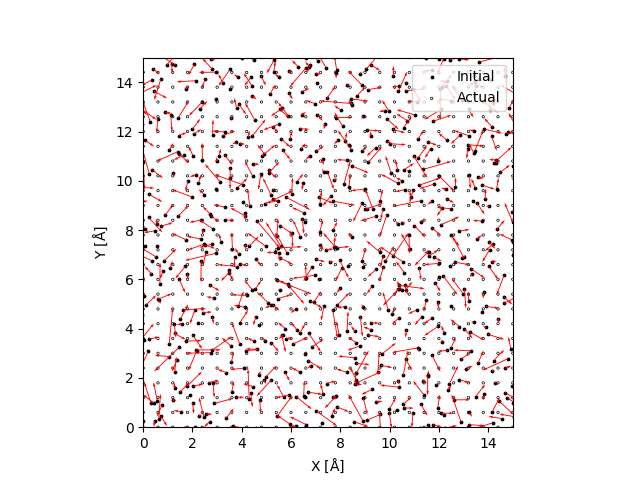

In [52]:
fig, ax = pyplot.subplots()

ax.scatter(to_numpy(init_scan[..., 1]).flatten(), to_numpy(init_scan[..., 0]).flatten(), marker='o', s=3, color='black', label="Initial")
ax.scatter(to_numpy(true_scan[..., 1]).flatten(), to_numpy(true_scan[..., 0]).flatten(), facecolors='none', edgecolors='black', marker='o', linewidth=0.5, s=3, label="Actual")

ax.quiver(to_numpy(init_scan[..., 1]).flatten(), to_numpy(init_scan[..., 0]).flatten(), scan_update_x, scan_update_y, color='red',
          angles='xy', scale_units='xy', scale=1)

ax.set_xlim([0., 15.])
ax.set_ylim([0., 15.])

ax.set_xlabel("X [$\\mathrm{\\AA}$]")
ax.set_ylabel("Y [$\\mathrm{\\AA}$]")
ax.set_aspect(1.)

ax.legend(loc='upper right')
pyplot.show()

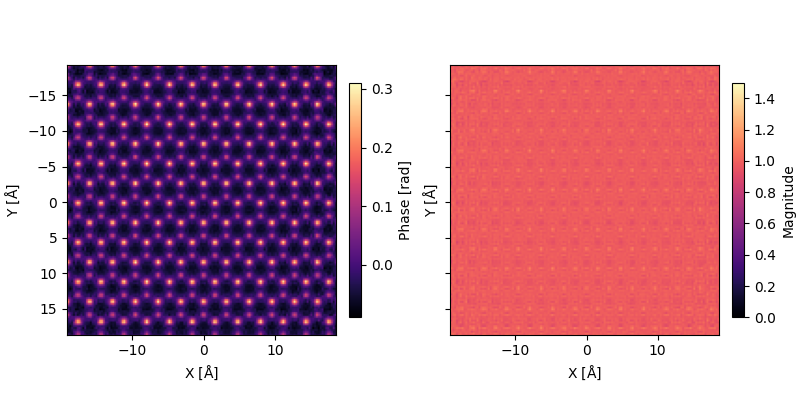

In [53]:
from phaser.utils.plotting import plot_object_phase, plot_object_mag

fig, axs = pyplot.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
fig.set_size_inches(8., 4.)

fig.colorbar(plot_object_phase(mod_state.object, ax=axs[0], cmap='magma'), label="Phase [rad]", shrink=0.6)
fig.colorbar(plot_object_mag(mod_state.object, ax=axs[1], cmap='magma', vmin=0., vmax=1.5), label="Magnitude", shrink=0.6)

pyplot.show()